In [3]:
import pandas as pd
import numpy as np
import datetime

In [2]:
# Load dataframes
df_purchases = pd.read_pickle("../processed_dataframes/df_purchases.pkl")
df_purchases['datetime'] = pd.to_datetime(df_purchases['datetime'])
df_purchases.set_index('datetime', inplace=True)
print(df_purchases.shape)
print(df_purchases.info())

(1673963, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1673963 entries, 2023-01-29 00:01:17 to 2023-02-19 22:50:13
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   timestamp  1673963 non-null  int64 
 1   user       1673963 non-null  object
 2   src        1673963 non-null  object
 3   out        1673963 non-null  object
 4   time       1673963 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 76.6+ MB
None


## Graph purchases last week. Interpolated

In [3]:
# Interpolates values in a dataframe that only when there's more than x (limit_low) consecutive NaN but less than limit_high consecutive Nan
def interpolate_limit(df, limit_low, limit_high):
    df = df.copy(deep=True) # so it doesn't modify the original df
    notnull = pd.notnull(df).all(axis=1)
    # assign group numbers to the rows of df. Each group starts with a non-null row,
    # followed by null rows
    group = notnull.cumsum()
    # find the index of groups having length > limit
    ignore = (df.groupby(group).filter(lambda grp: ((len(grp)<limit_low) or (len(grp)>limit_high)))).index
    # only ignore rows which are null
    ignore = df.loc[~notnull].index.intersection(ignore)
    keep = df.index.difference(ignore)
    # interpolate only the kept rows
    df.loc[keep] = df.loc[keep].fillna((df.ffill()+df.bfill())/2)
    
    return df

In [6]:
# Extracts a subset of a dataframe between a start and an end date and time.
def get_df_period(df, startdatetime, enddatetime):
    mask = (df.index >= startdatetime) & (df.index <= enddatetime)
    print(f"Getting dataframe between {startdatetime} and {enddatetime}")
    df_period = df[mask]
    return df_period

In [5]:
# Function to obtain a resampled dataframe with a row per second, with NaN values interpolated
def get_df_bysecond_interpolated(df_purchases):
    # Empty dataframe with a row for each second between two datetimes
    df2 = pd.DataFrame(0, index=pd.date_range(startdate, enddate, freq="1s"), columns=['values']) # temporary empty df where the index are all seconds on that period
    print(df2.shape)
    
    # Extract subset of df_purchases between the start and end dates
    df_subset = get_df_period(df_purchases, startdate, enddate)
    df_by_second = df_subset.combine_first(df2) # adds 
    print(df_by_second.shape)

    # Now resample per second:
    df_by_second = df_by_second.resample("1s").count()
    df_by_second.replace(0, np.nan, inplace=True) # 0 to NaN
    
    # Apply interpolate_rolling_limit()
    df_by_second_interpolated_limit = interpolate_limit(df_by_second, 60, 1500)
    print(df_by_second_interpolated_limit.shape)
    
    return df_by_second_interpolated_limit

(604801, 1)
Getting dataframe between 2023-02-12 23:01:40 and 2023-02-19 23:01:40
(732990, 6)
(604801, 6)


<AxesSubplot: >

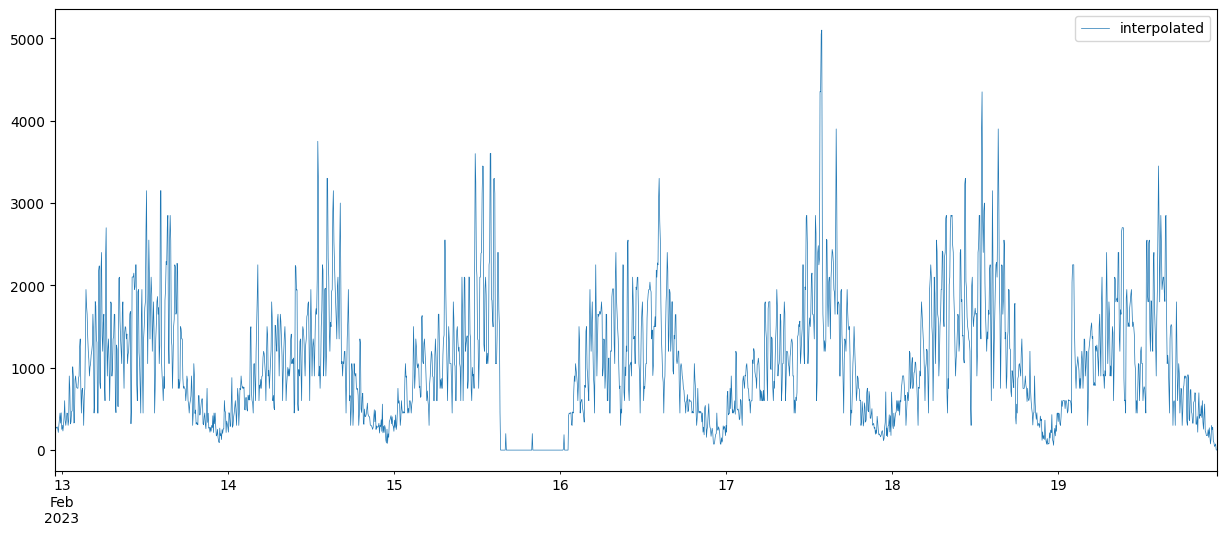

In [6]:
enddate = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # right now, to string
startdate = datetime.datetime.strptime(enddate, '%Y-%m-%d %H:%M:%S')
startdate -= datetime.timedelta(seconds=604800) # a day ago
startdate = startdate.strftime("%Y-%m-%d %H:%M:%S") # convert back to string


df_by_second_interpolated = get_df_bysecond_interpolated(df_purchases)
df_byminute_interpolated_limit = df_by_second_interpolated.resample("5T").sum()
df_byminute_interpolated_limit.plot(y='out', figsize=(15, 6), lw=0.5, label='interpolated')

## User heatmap for last week

In [7]:
# Returns a dataframe matrix of the top 50 users with most purchases during the last week
def get_df_top_users(df_purchases):

    # add timestamp feature
    df_purchases['timestamp'] = pd.to_datetime(df_purchases['timestamp'], unit='s', origin='unix')

    # Find the top X users by occurrence
    X = 50
    top_users = df_purchases['user'].value_counts().sort_values(ascending=False).head(X).index.tolist()
    print(top_users)

    # Create an empty dataframe to store the data for the top X users
    df_top_users = pd.DataFrame()

    # Iterate over the top X users
    for user in top_users:
      # Select the rows for the current user
      user_df = df_purchases[df_purchases['user'] == user]

      # Group the data by day and count the occurrences
      grouped_df = user_df.groupby(user_df['timestamp']).size().reset_index(name='count')

      # Set the timestamp column as the index of the dataframe
      grouped_df['timestamp'] = pd.to_datetime(grouped_df['timestamp'], infer_datetime_format=True)
      grouped_df.set_index('timestamp', inplace=True)

      # Create a new dataframe with a row for each date
      dates_df = grouped_df.resample('D').count()

      # Fill the missing values with zeros
      dates_df.fillna(0, inplace=True)

      # Append the data for the current user to the top_users_df dataframe as a new column
      df_top_users = pd.concat([df_top_users, dates_df], axis=1)

    # Rename the columns of the df_top_users dataframe using the list of top users
    df_top_users.columns = top_users

    # Fill the missing values with zeros
    df_top_users.fillna(0, inplace=True)
    
    return df_top_users

In [12]:
# Import dataframe
df_purchases = pd.read_pickle("../processed_dataframes/df_purchases.pkl")
df_purchases['datetime'] = pd.to_datetime(df_purchases['datetime'])
df_purchases.set_index('datetime', inplace=True)

# Limit to one week from now
enddate = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # right now, to string
startdate = datetime.datetime.strptime(enddate, '%Y-%m-%d %H:%M:%S')
startdate -= datetime.timedelta(seconds=604800) # a day ago
startdate = startdate.strftime("%Y-%m-%d %H:%M:%S") # convert back to string
df_purchases = get_df_period(df_purchases, startdate, enddate)

df_top_users = get_df_top_users(df_purchases)
display(df_top_users)

Getting dataframe between 2023-02-12 23:41:45 and 2023-02-19 23:41:45
['SY***-V9EL', 'SG***-S8GL', 'AN***-YLHQ', 'SY***-DYXQ', 'AK***-VZFG', 'A7***-UAHQ', 'AQ***-XBFN', 'AY***-U2GG', 'SE***-8YBJ', 'SX***-56FC', 'S7***-ZMEQ', 'A6***-7DAA', 'SR***-UZGG', 'AS***-XZEG', 'A7***-9EVE', 'S2***-YMZA', 'SM***-M5AQ', 'SB***-ADHQ', 'AD***-AYBC', 'A7***-WMHN', 'SP***-XMFQ', 'AX***-3YAE', 'AD***-AMSQ', 'AE***-46NE', 'SD***-78EA', 'AB***-5NRG', 'AW***-HNNL', 'AX***-U8HA', 'A6***-XKGN', 'SM***-SBEQ', 'S2***-VZHG', 'SU***-S5UJ', 'ST***-UNFQ', 'S4***-WYEG', 'S7***-U3HG', 'A8***-W3GG', 'SZ***-F3ZJ', 'AP***-69PE', 'AZ***-SWEA', 'AL***-BKRJ', 'A6***-A8ZA', 'AM***-3HQQ', 'A7***-QBNE', 'SM***-6YGC', 'AZ***-SJVJ', 'SB***-B6SQ', 'SQ***-8YRJ', 'SP***-RYTL', 'A3***-F2GN', 'SK***-LCEN']


,SY***-V9EL,SG***-S8GL,AN***-YLHQ,SY***-DYXQ,AK***-VZFG,A7***-UAHQ,AQ***-XBFN,AY***-U2GG,SE***-8YBJ,SX***-56FC,...,A6***-A8ZA,AM***-3HQQ,A7***-QBNE,SM***-6YGC,AZ***-SJVJ,SB***-B6SQ,SQ***-8YRJ,SP***-RYTL,A3***-F2GN,SK***-LCEN
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-12,10.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-13,65.0,213.0,24.0,3.0,27.0,58.0,29.0,15.0,190.0,0.0,...,3.0,58.0,0.0,0.0,8.0,34.0,0.0,0.0,0.0,2.0
2023-02-14,199.0,49.0,199.0,0.0,184.0,72.0,180.0,174.0,0.0,0.0,...,5.0,50.0,0.0,0.0,4.0,10.0,0.0,0.0,0.0,6.0
2023-02-15,47.0,0.0,41.0,0.0,25.0,94.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,1.0,0.0
2023-02-16,0.0,19.0,0.0,215.0,0.0,0.0,0.0,0.0,0.0,46.0,...,9.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,52.0
2023-02-17,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,8.0,23.0,...,63.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,17.0
2023-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0,...,17.0,0.0,108.0,1.0,38.0,0.0,0.0,102.0,101.0,0.0
2023-02-19,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63.0,...,10.0,0.0,0.0,106.0,8.0,61.0,105.0,0.0,0.0,21.0


In [13]:
import plotly.express as px

#top_users_df = top_users_df.transpose()

fig = px.imshow(df_top_users)
fig.show()